# Detection of an unknown pulsar and measurement of its period

In [2]:
# Preamble and imports
from __future__ import (print_function, absolute_import, division)

import os
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib
from math import pi

%matplotlib inline

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

## 1. Importing Data

In [23]:
# Get the directory with the data
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP", "FFT")
# List all the data files
print("Files avaliable:", os.listdir(data_dir))

def get_header(file_name):
    file_name = file_name + '.hdr'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        lines = dfile.readlines()
        for i, line in enumerate(lines):
            lines[i] = line.strip()
    
    return lines


def get_data(file_name):
    file_name = file_name + '.dat'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        data = np.fromfile(dfile)
    
    return data

Files avaliable: ['psr3.hdr', 'psr1.hdr', 'psr4.dat', 'psr1.dat', 'psr5.hdr', 'psr2.dat', 'psr2.hdr', 'psr5.dat', 'psr4.hdr', 'psr0.dat', 'psr3.dat', 'psr0.hdr']


## Fourier transform Demo

This demo code will generate a sinusoid burried in random noise, and will demonstrate the power of the Fourier transform to identify periodic signals in the data.

You should run and experiment with this code before adapting it to compute the Fourier transform of your pulsar data.

Tsamp = 0.010000 seconds
Total observation time is 2621.440000 seconds


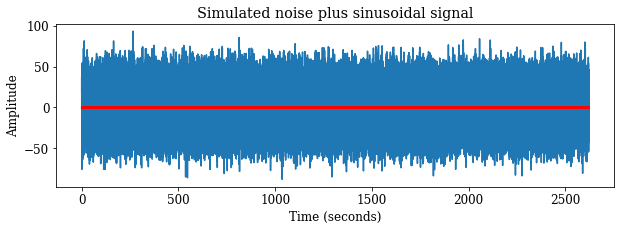

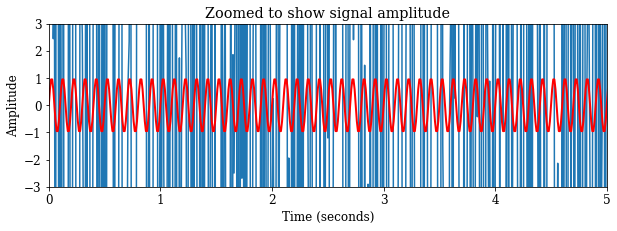

In [22]:
# Sample interval
dt = 0.01 
print("Tsamp = %f seconds"%(dt))


# Read raw data as a stream of bytes
# Simulate a sinusoid and some noise
npts = 262144
t = np.linspace(0,(npts-1)*dt,npts)

# The period of our sinusoid
period = 0.1

# Random noise
random_noise = np.random.normal(0,20,npts)

# Generating fake signal
fake_signal  = np.sin(2*pi*t/period)

# Add them up together
raw_bytes = random_noise + fake_signal


# We can plot the data.
print("Total observation time is %f seconds"%(t[-1] + dt))
plt.figure(figsize=(10,3))
plt.plot(t,raw_bytes)

# Overplot the simulated signal in red
# Notice it gets lost in the noise
plt.plot(t,fake_signal,color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Simulated noise plus sinusoidal signal")


# Create a new figure with zoomed in signal
plt.figure(figsize=(10,3))
plt.plot(t,raw_bytes)
plt.plot(t,fake_signal,color='red',linewidth=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Zoomed to show signal amplitude")
plt.xlim(0,5)
plt.ylim(-3,3)
plt.show()

## The FFT

This part of the code executes the Fourier transform using the Fast Fourier transform algorithm (FFT). See the numpy reference page for the FFT module for an understanding of what the algorithm actually computes.

https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html

In this demo, we use the "rfft" routine since we are computing a transform on real data. You will need to compute the x-values to plot for the frequency axis. Check that the frequency of the signal in your power spectrum matches the period you set in the simulation code.

For your real data, you might have some very strong signals, and therefore have to re-scale the axes to identify the pulsar signals. It could help to first plot the logarithm of the power to compress the brightest signals.

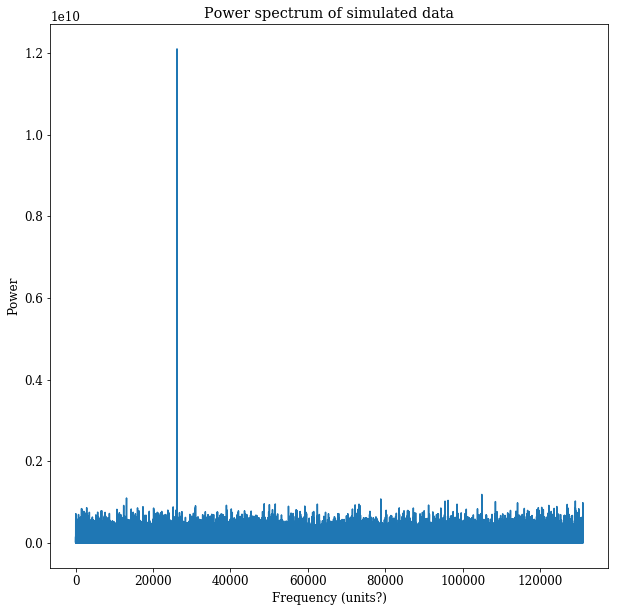

In [6]:
ft = np.fft.rfft(raw_bytes)

# The Fourier transform of a real-valued sequence sill creates complex values. 
# Here we just take the "power spectrum".

power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)

plt.figure(figsize=(10,10))
plt.plot(power)
plt.xlabel("Frequency (units?)")
plt.ylabel("Power")
plt.title("Power spectrum of simulated data")

plt.show()